# Noise Reduction 

***
***

## Import Modules

In [244]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from jupyterthemes import jtplot
jtplot.reset()
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [245]:
import importlib
import Arduino_NoiseReduction_Code as NR

In [246]:
importlib.reload(NR)

<module 'Arduino_NoiseReduction_Code' from 'd:\\GitHub\\physics_laboratory_2020_2021\\CATENA ELETTRONICA\\Python\\Arduino_NoiseReduction_Code.py'>

## Fit Functions

In [247]:
####### LINEAR FUCTION
def lin(x, a, b):  
    return a + b * x

####### EXPONENTIAL FUCTION
def esp(x, a, b, c):  
    return a + b * np.exp(- x * c**-1)

## Arduino Calibration

### Choose the right calibration function:

Since the signal we are going to acquire with Arduino has an amplitude between 300mV and 400mV we choose not to consider high tension inputs for the calibration. Higher tension inputs have a totally different trend: we will use them (and only them) if we find an high tension signal to acquire.

In [248]:
# READ DATA
data_low = NR.arduino_calib_read_low()

# ERROR PROPAGATION
data_low['err Vin'] = NR.propagazione_cursori(data_low['Vdiv'], data_low['Vin'])

# PERFORM THE FIT
par, cov = curve_fit(f = lin, xdata = data_low['max_values'], ydata = data_low['Vin'])

# GET FIT PARAMETERS AND PARAMETER ERRORS
error = []
for i in range(len(par)):
    try:
        error.append(np.absolute(cov[i][i])**0.5)
    except:
        error.append( 0.00 )
fit_par = par
fit_err = np.array(error)
arduino_calib_offset = fit_par[0]
arduino_calib_slope = fit_par[1]
arduino_calib_offset_err = fit_err[0]
arduino_calib_slope_err = fit_err[1]

# PRINT CALIBRATION FUNCTION
print(
        'VOLT = ' +  ' (' + format(arduino_calib_offset, '.3f') + ' +/- ' + format(arduino_calib_offset_err, '.3f') + ') ' + ' + ' 
        + ' (' + format(arduino_calib_slope, '.6f') + ' +/- ' + format(arduino_calib_slope_err, '.6f') + ') ' + ' ADC'
    )


VOLT =  (-0.637 +/- 0.010)  +  (0.000828 +/- 0.000007)  ADC


## Check the Waveform acquired

In [249]:
# READ DATA FROM FILE
file_name = '../Data/PreAmp/data_arduino.dat'

data = pd.read_csv(file_name, index_col = False, header = None, sep = ' ')
data.index = np.arange(1, len(data)+1)

data.columns = ['time', 'ADC']

# CALIBRATION
SAMPLING = 955000

data['time (ms)'] = data['time'] * 1e3 * SAMPLING**-1
data['V (V)']  = arduino_calib_offset + arduino_calib_slope * data['ADC']
data['err V (V)'] = np.sqrt(arduino_calib_offset_err**2 + arduino_calib_slope_err**2)

# PRINT DATA
data

,time,ADC,time (ms),V (V),err V (V)
1,1,795,0.001047,0.021977,0.009805
2,2,793,0.002094,0.020320,0.009805
3,3,793,0.003141,0.020320,0.009805
4,4,798,0.004188,0.024462,0.009805
5,5,795,0.005236,0.021977,0.009805
...,...,...,...,...,...
2043,2043,793,2.139267,0.020320,0.009805
2044,2044,776,2.140314,0.006239,0.009805
2045,2045,787,2.141361,0.015350,0.009805
2046,2046,788,2.142408,0.016178,0.009805


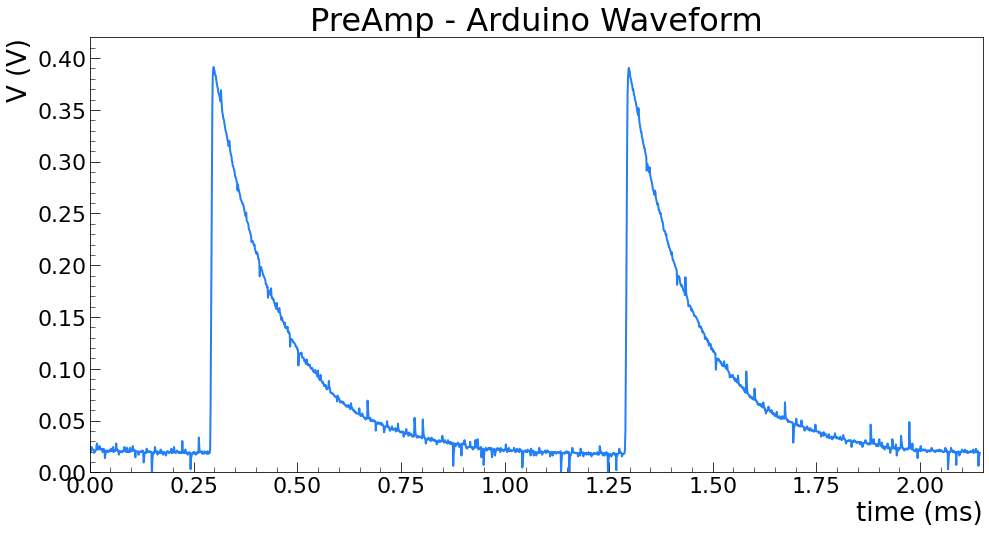

In [250]:
# PLOT DATA
NR.arduino_waveform(data)

As we can see data is a bit noisy, especially the lower tension range between 0 and 100mV

## Noise Reduction: 1st attempt

### Apply an IIR filter to data

In [251]:
import scipy.signal as signal

Here we set up the IIR filter by choosing manually the parameters:

* _b_ will be the numerator coefficient
* _a_ will be the denominator coefficient
* _n_ will be a parameter that determines the overall smoothness of the curve

In [252]:
# we take a quite small n as for higher n values 
# we get a strong deviation from the initial data points
# = not good
n = 5  
b = [1.0 / n] * n
a = 1

# we apply the filter to data
data['V filter'] = signal.lfilter(b, a, data['V (V)'])

# LET'S ANALIZE JUST THE FIRST PEEK OF THE DATA
data_peek = data.loc[(data['time (ms)'] > 0.3) & (data['time'] < 1200 )]

data_peek

,time,ADC,time (ms),V (V),err V (V),V filter
287,287,1237,0.300524,0.388095,0.009805,0.387929
288,288,1233,0.301571,0.384782,0.009805,0.388426
289,289,1231,0.302618,0.383125,0.009805,0.387267
290,290,1231,0.303665,0.383125,0.009805,0.385610
291,291,1226,0.304712,0.378983,0.009805,0.383622
...,...,...,...,...,...,...
1195,1195,789,1.251309,0.017007,0.009805,0.011540
1196,1196,789,1.252356,0.017007,0.009805,0.011208
1197,1197,790,1.253403,0.017835,0.009805,0.015350
1198,1198,789,1.254450,0.017007,0.009805,0.016841


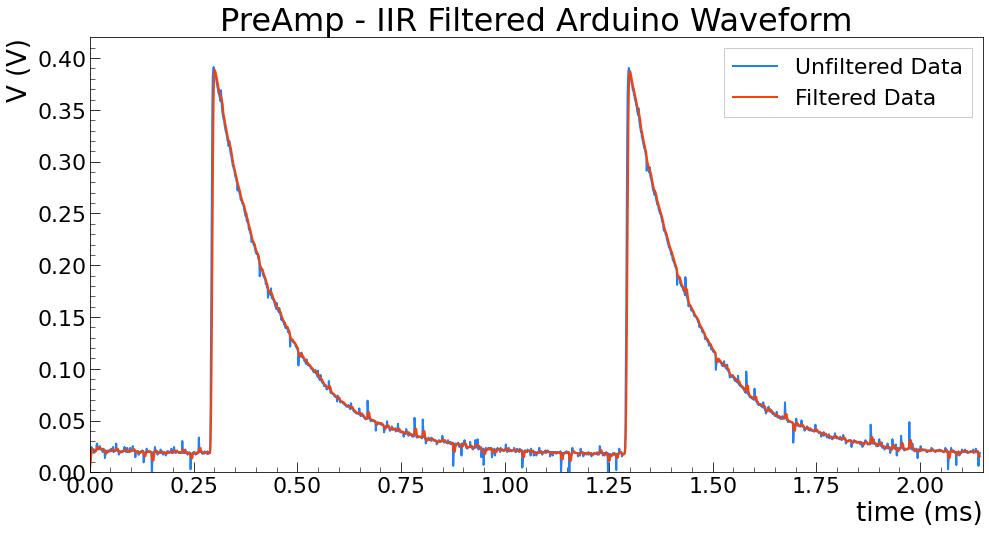

In [253]:
NR.arduino_waveform_IIR_filter(data)

So far so good. Let's take a closer look at the first peek.

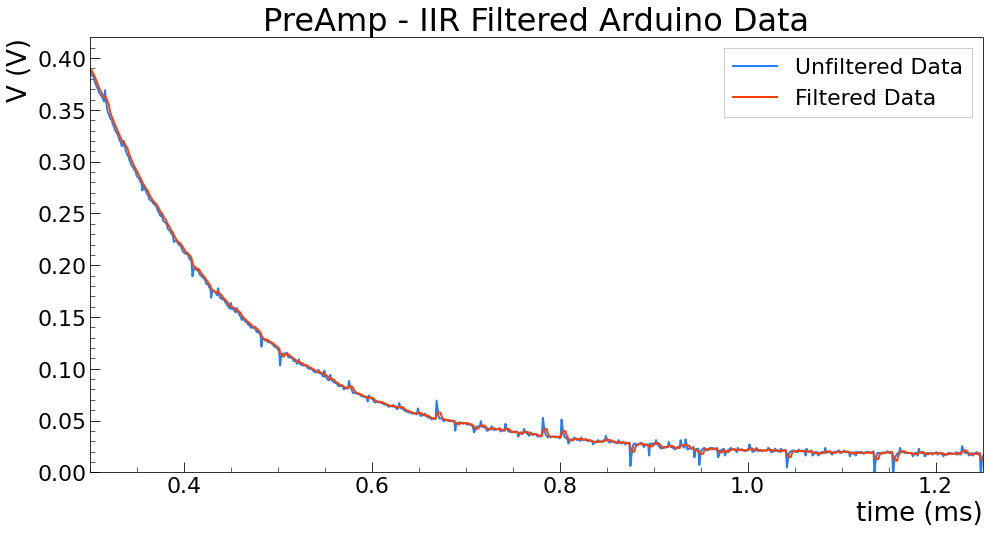

In [254]:
NR.arduino_waveform_IIR_filter_peek(data_peek)

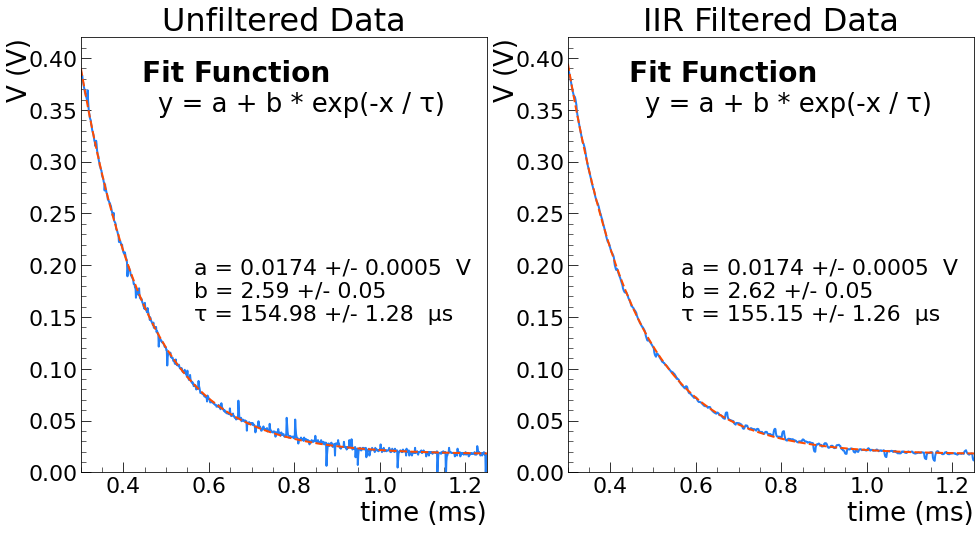

In [255]:
NR.arduino_IIR_exp_fit(data_peek)

## Noise Reduction: 2nd attempt

### Apply a Butterworth filter to data

I'd like to use a moving average filter but, as it is technically a low-pass filter, it is just easier to apply a low pass filter.

In [256]:
# Desing the Butterworth filter
N  = 3    # Filter order
Wn = 0.1  # Cutoff frequency (normalized)
B, A = signal.butter(N, Wn, output = 'ba')

# WE APPLY THE FILTER JUST TO THE FIRST PEEK FOR BETTER RESULTS
data_peek['V filter2'] = signal.filtfilt(B, A, data_peek['V (V)'])

data_peek

,time,ADC,time (ms),V (V),err V (V),V filter,V filter2
287,287,1237,0.300524,0.388095,0.009805,0.387929,0.387999
288,288,1233,0.301571,0.384782,0.009805,0.388426,0.385580
289,289,1231,0.302618,0.383125,0.009805,0.387267,0.383212
290,290,1231,0.303665,0.383125,0.009805,0.385610,0.380910
291,291,1226,0.304712,0.378983,0.009805,0.383622,0.378684
...,...,...,...,...,...,...,...
1195,1195,789,1.251309,0.017007,0.009805,0.011540,0.014159
1196,1196,789,1.252356,0.017007,0.009805,0.011208,0.014314
1197,1197,790,1.253403,0.017835,0.009805,0.015350,0.014536
1198,1198,789,1.254450,0.017007,0.009805,0.016841,0.014808


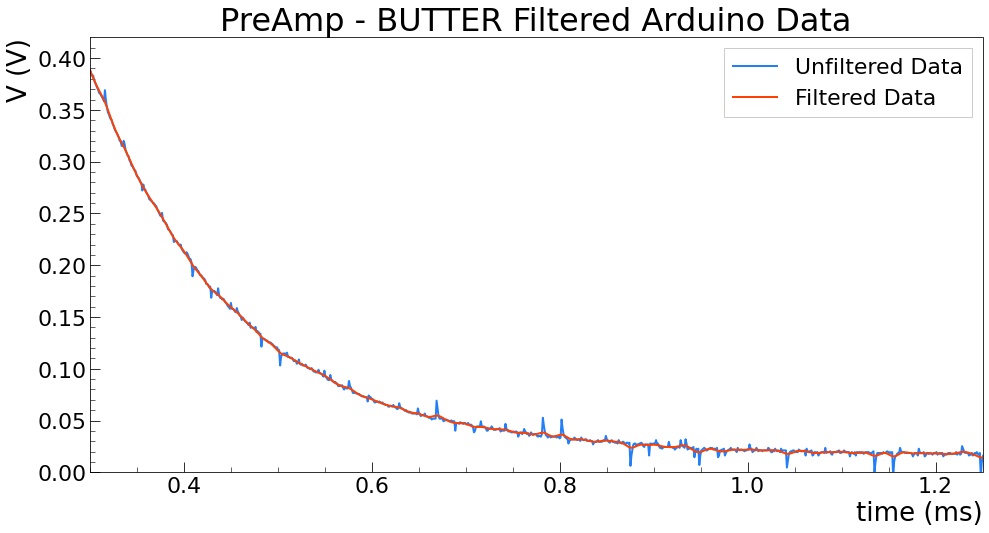

In [257]:
NR.arduino_waveform_BUTTER_filter_peek(data_peek)

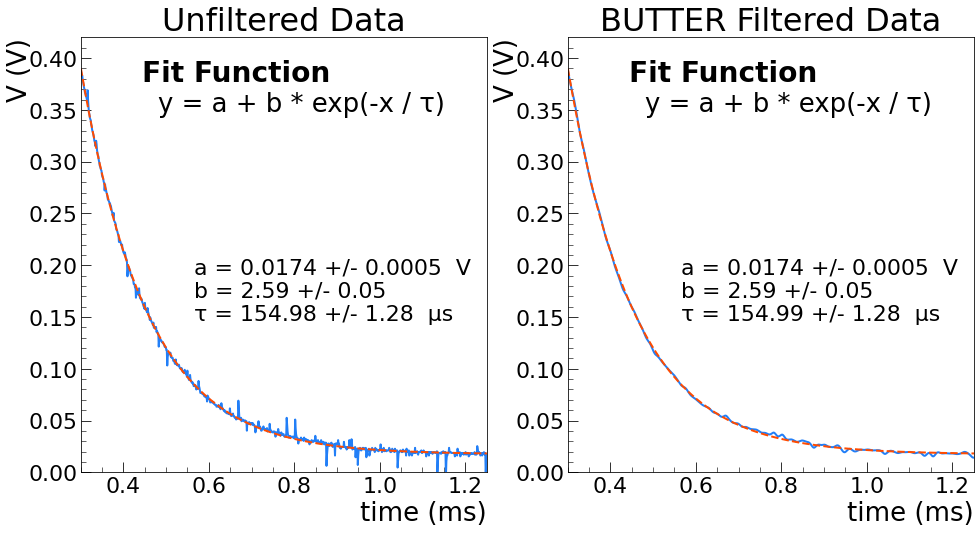

In [258]:
NR.arduino_BUTTER_exp_fit(data_peek)